# Method 3 - Best Ideas High Minus Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
low_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

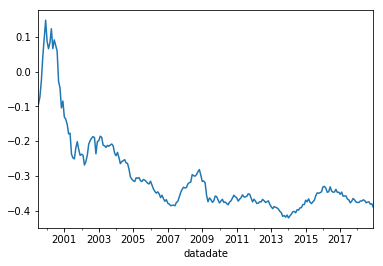

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.147632
2000-12-31   -0.202427
2001-12-31   -0.170674
2002-12-31    0.051905
2003-12-31   -0.041250
2004-12-31   -0.097802
2005-12-31   -0.020038
2006-12-31   -0.066474
2007-12-31    0.056365
2008-12-31    0.051929
2009-12-31   -0.101477
2010-12-31    0.014537
2011-12-31   -0.022944
2012-12-31   -0.011167
2013-12-31   -0.049903
2014-12-31    0.051359
2015-12-31    0.059398
2016-12-31   -0.001810
2017-12-31   -0.043321
2018-12-31   -0.024079
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     12.63
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.65e-09
Time:                        13:32:35   Log-Likelihood:                 609.95
No. Observations:                 234   AIC:                            -1210.
Df Residuals:                     229   BIC:                            -1193.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -2.076      0.039      -0.005      -0.000
mktrf          0.0564      0.034      1.677      0.095      -0.010       0.123
me            -0.0485      0.039     -1.240      0.216      -0.126       0.029
ia            -0.2205      0.060     -3.706      0.000      -0.338      -0.103
roe            0.2877      0.051      5.649      0.000       0.187       0.388
==============================================================================
Omnibus:                       47.847   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.283
Skew:                          -0.695   Prob(JB):                     8.89e-49
Kurtosis:                       7.557   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     13.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.03e-09
Time:                        13:32:35   Log-Likelihood:                 609.95
No. Observations:                 234   AIC:                            -1210.
Df Residuals:                     229   BIC:                            -1193.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -1.817      0.069      -0.005       0.000
mktrf          0.0564      0.038      1.496      0.135      -0.017       0.130
me            -0.0485      0.036     -1.358      0.174      -0.119       0.022
ia            -0.2205      0.108     -2.051      0.040      -0.431      -0.010
roe            0.2877      0.054      5.287      0.000       0.181       0.394
==============================================================================
Omnibus:                       47.847   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.283
Skew:                          -0.695   Prob(JB):                     8.89e-49
Kurtosis:                       7.557   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     15.93
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.60e-11
Time:                        13:32:35   Log-Likelihood:                 609.95
No. Observations:                 234   AIC:                            -1210.
Df Residuals:                     229   BIC:                            -1193.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -1.898      0.058      -0.005    8.34e-05
mktrf          0.0564      0.043      1.322      0.186      -0.027       0.140
me            -0.0485      0.029     -1.686      0.092      -0.105       0.008
ia            -0.2205      0.119     -1.851      0.064      -0.454       0.013
roe            0.2877      0.051      5.696      0.000       0.189       0.387
==============================================================================
Omnibus:                       47.847   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.283
Skew:                          -0.695   Prob(JB):                     8.89e-49
Kurtosis:                       7.557   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     5.070
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000199
Time:                        13:32:35   Log-Likelihood:                 598.96
No. Observations:                 234   AIC:                            -1186.
Df Residuals:                     228   BIC:                            -1165.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -1.077      0.283      -0.004       0.001
mktrf         -0.0151      0.035     -0.425      0.671      -0.085       0.055
smb           -0.0874      0.047     -1.870      0.063      -0.180       0.005
hml           -0.1220      0.055     -2.213      0.028      -0.231      -0.013
rmw            0.0881      0.062      1.414      0.159      -0.035       0.211
cma           -0.0954      0.079     -1.205      0.229      -0.252       0.061
==============================================================================
Omnibus:                       48.733   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.542
Skew:                          -0.759   Prob(JB):                     1.27e-43
Kurtosis:                       7.237   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     5.294
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000127
Time:                        13:32:35   Log-Likelihood:                 598.96
No. Observations:                 234   AIC:                            -1186.
Df Residuals:                     228   BIC:                            -1165.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -1.123      0.262      -0.004       0.001
mktrf         -0.0151      0.038     -0.401      0.688      -0.089       0.059
smb           -0.0874      0.064     -1.357      0.175      -0.214       0.039
hml           -0.1220      0.056     -2.186      0.029      -0.231      -0.013
rmw            0.0881      0.084      1.055      0.291      -0.076       0.252
cma           -0.0954      0.126     -0.758      0.448      -0.342       0.151
==============================================================================
Omnibus:                       48.733   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.542
Skew:                          -0.759   Prob(JB):                     1.27e-43
Kurtosis:                       7.237   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     5.916
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.65e-05
Time:                        13:32:35   Log-Likelihood:                 598.96
No. Observations:                 234   AIC:                            -1186.
Df Residuals:                     228   BIC:                            -1165.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -1.224      0.221      -0.004       0.001
mktrf         -0.0151      0.042     -0.359      0.720      -0.097       0.067
smb           -0.0874      0.060     -1.460      0.144      -0.205       0.030
hml           -0.1220      0.050     -2.436      0.015      -0.220      -0.024
rmw            0.0881      0.079      1.114      0.265      -0.067       0.243
cma           -0.0954      0.119     -0.800      0.423      -0.329       0.138
==============================================================================
Omnibus:                       48.733   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.542
Skew:                          -0.759   Prob(JB):                     1.27e-43
Kurtosis:                       7.237   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     18.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.15e-13
Time:                        13:32:35   Log-Likelihood:                 618.97
No. Observations:                 234   AIC:                            -1228.
Df Residuals:                     229   BIC:                            -1211.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.001     -1.953      0.052      -0.005    2.06e-05
mktrf          0.0575      0.030      1.929      0.055      -0.001       0.116
smb           -0.1694      0.037     -4.552      0.000      -0.243      -0.096
hml           -0.1133      0.037     -3.066      0.002      -0.186      -0.040
umd            0.1693      0.024      6.979      0.000       0.122       0.217
==============================================================================
Omnibus:                       56.005   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              288.255
Skew:                          -0.809   Prob(JB):                     2.55e-63
Kurtosis:                       8.191   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     11.11
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.98e-08
Time:                        13:32:35   Log-Likelihood:                 618.97
No. Observations:                 234   AIC:                            -1228.
Df Residuals:                     229   BIC:                            -1211.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.001     -1.843      0.065      -0.005       0.000
mktrf          0.0575      0.049      1.178      0.239      -0.038       0.153
smb           -0.1694      0.055     -3.066      0.002      -0.278      -0.061
hml           -0.1133      0.059     -1.921      0.055      -0.229       0.002
umd            0.1693      0.029      5.791      0.000       0.112       0.227
==============================================================================
Omnibus:                       56.005   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              288.255
Skew:                          -0.809   Prob(JB):                     2.55e-63
Kurtosis:                       8.191   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     10.87
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.36e-08
Time:                        13:32:35   Log-Likelihood:                 618.97
No. Observations:                 234   AIC:                            -1228.
Df Residuals:                     229   BIC:                            -1211.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.001     -1.857      0.063      -0.005       0.000
mktrf          0.0575      0.054      1.061      0.289      -0.049       0.164
smb           -0.1694      0.060     -2.801      0.005      -0.288      -0.051
hml           -0.1133      0.068     -1.673      0.094      -0.246       0.019
umd            0.1693      0.028      6.123      0.000       0.115       0.223
==============================================================================
Omnibus:                       56.005   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              288.255
Skew:                          -0.809   Prob(JB):                     2.55e-63
Kurtosis:                       8.191   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     8.021
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.70e-06
Time:                        13:32:35   Log-Likelihood:                 284.43
No. Observations:                 120   AIC:                            -558.9
Df Residuals:                     115   BIC:                            -544.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -1.766      0.080      -0.008       0.000
mktrf          0.0962      0.060      1.615      0.109      -0.022       0.214
me            -0.0311      0.059     -0.529      0.598      -0.148       0.085
ia            -0.3115      0.092     -3.382      0.001      -0.494      -0.129
roe            0.3714      0.082      4.556      0.000       0.210       0.533
==============================================================================
Omnibus:                       14.105   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.621
Skew:                          -0.528   Prob(JB):                     7.43e-06
Kurtosis:                       4.900   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     10.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.46e-07
Time:                        13:32:35   Log-Likelihood:                 284.43
No. Observations:                 120   AIC:                            -558.9
Df Residuals:                     115   BIC:                            -544.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.003     -1.526      0.127      -0.009       0.001
mktrf          0.0962      0.057      1.699      0.089      -0.015       0.207
me            -0.0311      0.041     -0.758      0.449      -0.111       0.049
ia            -0.3115      0.141     -2.205      0.027      -0.588      -0.035
roe            0.3714      0.071      5.201      0.000       0.231       0.511
==============================================================================
Omnibus:                       14.105   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.621
Skew:                          -0.528   Prob(JB):                     7.43e-06
Kurtosis:                       4.900   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     16.19
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.52e-10
Time:                        13:32:35   Log-Likelihood:                 284.43
No. Observations:                 120   AIC:                            -558.9
Df Residuals:                     115   BIC:                            -544.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -1.659      0.097      -0.009       0.001
mktrf          0.0962      0.061      1.569      0.117      -0.024       0.216
me            -0.0311      0.030     -1.040      0.298      -0.090       0.027
ia            -0.3115      0.151     -2.058      0.040      -0.608      -0.015
roe            0.3714      0.062      6.035      0.000       0.251       0.492
==============================================================================
Omnibus:                       14.105   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.621
Skew:                          -0.528   Prob(JB):                     7.43e-06
Kurtosis:                       4.900   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.702
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0240
Time:                        13:32:35   Log-Likelihood:                 276.38
No. Observations:                 120   AIC:                            -540.8
Df Residuals:                     114   BIC:                            -524.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -0.854      0.395      -0.007       0.003
mktrf         -0.0457      0.067     -0.677      0.500      -0.179       0.088
smb           -0.1107      0.076     -1.449      0.150      -0.262       0.041
hml           -0.1316      0.094     -1.406      0.163      -0.317       0.054
rmw            0.0661      0.110      0.599      0.550      -0.153       0.285
cma           -0.1418      0.121     -1.173      0.243      -0.381       0.098
==============================================================================
Omnibus:                       13.949   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.491
Skew:                          -0.558   Prob(JB):                     2.15e-05
Kurtosis:                       4.747   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.645
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00426
Time:                        13:32:35   Log-Likelihood:                 276.38
No. Observations:                 120   AIC:                            -540.8
Df Residuals:                     114   BIC:                            -524.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -0.908      0.364      -0.007       0.002
mktrf         -0.0457      0.061     -0.743      0.457      -0.166       0.075
smb           -0.1107      0.088     -1.263      0.207      -0.282       0.061
hml           -0.1316      0.096     -1.369      0.171      -0.320       0.057
rmw            0.0661      0.124      0.534      0.593      -0.177       0.309
cma           -0.1418      0.157     -0.902      0.367      -0.450       0.166
==============================================================================
Omnibus:                       13.949   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.491
Skew:                          -0.558   Prob(JB):                     2.15e-05
Kurtosis:                       4.747   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     5.851
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.55e-05
Time:                        13:32:35   Log-Likelihood:                 276.38
No. Observations:                 120   AIC:                            -540.8
Df Residuals:                     114   BIC:                            -524.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -1.055      0.291      -0.006       0.002
mktrf         -0.0457      0.065     -0.704      0.481      -0.173       0.081
smb           -0.1107      0.075     -1.475      0.140      -0.258       0.036
hml           -0.1316      0.084     -1.557      0.119      -0.297       0.034
rmw            0.0661      0.107      0.621      0.535      -0.143       0.275
cma           -0.1418      0.150     -0.947      0.344      -0.435       0.152
==============================================================================
Omnibus:                       13.949   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.491
Skew:                          -0.558   Prob(JB):                     2.15e-05
Kurtosis:                       4.747   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     12.82
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.15e-08
Time:                        13:32:35   Log-Likelihood:                 291.79
No. Observations:                 120   AIC:                            -573.6
Df Residuals:                     115   BIC:                            -559.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.002     -1.349      0.180      -0.007       0.001
mktrf          0.1003      0.049      2.033      0.044       0.003       0.198
smb           -0.2283      0.056     -4.064      0.000      -0.340      -0.117
hml           -0.1549      0.056     -2.753      0.007      -0.266      -0.043
umd            0.2118      0.035      6.106      0.000       0.143       0.280
==============================================================================
Omnibus:                       20.152   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.110
Skew:                          -0.585   Prob(JB):                     7.97e-12
Kurtosis:                       5.975   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     9.977
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.75e-07
Time:                        13:32:35   Log-Likelihood:                 291.79
No. Observations:                 120   AIC:                            -573.6
Df Residuals:                     115   BIC:                            -559.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.002     -1.506      0.132      -0.006       0.001
mktrf          0.1003      0.065      1.535      0.125      -0.028       0.228
smb           -0.2283      0.071     -3.216      0.001      -0.367      -0.089
hml           -0.1549      0.078     -1.981      0.048      -0.308      -0.002
umd            0.2118      0.035      6.000      0.000       0.143       0.281
==============================================================================
Omnibus:                       20.152   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.110
Skew:                          -0.585   Prob(JB):                     7.97e-12
Kurtosis:                       5.975   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     11.82
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.47e-08
Time:                        13:32:35   Log-Likelihood:                 291.79
No. Observations:                 120   AIC:                            -573.6
Df Residuals:                     115   BIC:                            -559.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.002     -1.667      0.095      -0.006       0.000
mktrf          0.1003      0.069      1.460      0.144      -0.034       0.235
smb           -0.2283      0.078     -2.923      0.003      -0.381      -0.075
hml           -0.1549      0.089     -1.749      0.080      -0.328       0.019
umd            0.2118      0.032      6.559      0.000       0.148       0.275
==============================================================================
Omnibus:                       20.152   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.110
Skew:                          -0.585   Prob(JB):                     7.97e-12
Kurtosis:                       5.975   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     5.613
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000380
Time:                        13:32:35   Log-Likelihood:                 371.05
No. Observations:                 114   AIC:                            -732.1
Df Residuals:                     109   BIC:                            -718.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.649      0.518      -0.003       0.001
mktrf         -0.0059      0.028     -0.211      0.834      -0.062       0.050
me            -0.0413      0.043     -0.954      0.342      -0.127       0.045
ia             0.0042      0.060      0.070      0.944      -0.115       0.123
roe            0.1931      0.053      3.656      0.000       0.088       0.298
==============================================================================
Omnibus:                        2.157   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                1.556
Skew:                           0.048   Prob(JB):                        0.459
Kurtosis:                       2.436   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     14.93
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.30e-10
Time:                        13:32:35   Log-Likelihood:                 371.05
No. Observations:                 114   AIC:                            -732.1
Df Residuals:                     109   BIC:                            -718.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.570      0.569      -0.003       0.002
mktrf         -0.0059      0.036     -0.165      0.869      -0.076       0.064
me            -0.0413      0.054     -0.770      0.441      -0.147       0.064
ia             0.0042      0.063      0.067      0.946      -0.119       0.127
roe            0.1931      0.040      4.792      0.000       0.114       0.272
==============================================================================
Omnibus:                        2.157   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                1.556
Skew:                           0.048   Prob(JB):                        0.459
Kurtosis:                       2.436   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     14.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.08e-09
Time:                        13:32:35   Log-Likelihood:                 371.05
No. Observations:                 114   AIC:                            -732.1
Df Residuals:                     109   BIC:                            -718.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.550      0.583      -0.003       0.002
mktrf         -0.0059      0.035     -0.168      0.866      -0.075       0.063
me            -0.0413      0.052     -0.796      0.426      -0.143       0.061
ia             0.0042      0.063      0.067      0.947      -0.119       0.128
roe            0.1931      0.039      4.928      0.000       0.116       0.270
==============================================================================
Omnibus:                        2.157   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                1.556
Skew:                           0.048   Prob(JB):                        0.459
Kurtosis:                       2.436   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     5.087
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000316
Time:                        13:32:35   Log-Likelihood:                 372.43
No. Observations:                 114   AIC:                            -732.9
Df Residuals:                     108   BIC:                            -716.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.538      0.591      -0.002       0.001
mktrf         -0.0112      0.027     -0.420      0.675      -0.064       0.042
smb           -0.0203      0.043     -0.470      0.639      -0.106       0.065
hml           -0.0541      0.055     -0.984      0.327      -0.163       0.055
rmw            0.2353      0.067      3.493      0.001       0.102       0.369
cma            0.0017      0.086      0.020      0.984      -0.168       0.171
==============================================================================
Omnibus:                        3.588   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                2.335
Skew:                          -0.147   Prob(JB):                        0.311
Kurtosis:                       2.364   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     7.120
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.61e-06
Time:                        13:32:35   Log-Likelihood:                 372.43
No. Observations:                 114   AIC:                            -732.9
Df Residuals:                     108   BIC:                            -716.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.458      0.647      -0.003       0.002
mktrf         -0.0112      0.036     -0.310      0.756      -0.082       0.059
smb           -0.0203      0.055     -0.367      0.713      -0.128       0.088
hml           -0.0541      0.048     -1.126      0.260      -0.148       0.040
rmw            0.2353      0.060      3.912      0.000       0.117       0.353
cma            0.0017      0.081      0.021      0.984      -0.157       0.161
==============================================================================
Omnibus:                        3.588   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                2.335
Skew:                          -0.147   Prob(JB):                        0.311
Kurtosis:                       2.364   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     6.412
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.97e-05
Time:                        13:32:35   Log-Likelihood:                 372.43
No. Observations:                 114   AIC:                            -732.9
Df Residuals:                     108   BIC:                            -716.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.437      0.662      -0.003       0.002
mktrf         -0.0112      0.039     -0.287      0.774      -0.087       0.065
smb           -0.0203      0.052     -0.393      0.694      -0.121       0.081
hml           -0.0541      0.036     -1.497      0.134      -0.125       0.017
rmw            0.2353      0.057      4.151      0.000       0.124       0.346
cma            0.0017      0.069      0.024      0.981      -0.133       0.136
==============================================================================
Omnibus:                        3.588   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                2.335
Skew:                          -0.147   Prob(JB):                        0.311
Kurtosis:                       2.364   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     3.389
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0118
Time:                        13:32:35   Log-Likelihood:                 367.06
No. Observations:                 114   AIC:                            -724.1
Df Residuals:                     109   BIC:                            -710.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.206      0.837      -0.002       0.002
mktrf         -0.0227      0.028     -0.826      0.411      -0.077       0.032
smb           -0.0725      0.043     -1.687      0.094      -0.158       0.013
hml           -0.0583      0.044     -1.317      0.191      -0.146       0.029
umd            0.0458      0.033      1.371      0.173      -0.020       0.112
==============================================================================
Omnibus:                        3.204   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                1.950
Skew:                           0.006   Prob(JB):                        0.377
Kurtosis:                       2.359   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     3.267
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0143
Time:                        13:32:35   Log-Likelihood:                 367.06
No. Observations:                 114   AIC:                            -724.1
Df Residuals:                     109   BIC:                            -710.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.174      0.862      -0.002       0.002
mktrf         -0.0227      0.038     -0.598      0.550      -0.097       0.052
smb           -0.0725      0.062     -1.160      0.246      -0.195       0.050
hml           -0.0583      0.057     -1.026      0.305      -0.170       0.053
umd            0.0458      0.045      1.013      0.311      -0.043       0.134
==============================================================================
Omnibus:                        3.204   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                1.950
Skew:                           0.006   Prob(JB):                        0.377
Kurtosis:                       2.359   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.407
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00243
Time:                        13:32:35   Log-Likelihood:                 367.06
No. Observations:                 114   AIC:                            -724.1
Df Residuals:                     109   BIC:                            -710.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.163      0.871      -0.003       0.002
mktrf         -0.0227      0.039     -0.587      0.557      -0.099       0.053
smb           -0.0725      0.061     -1.184      0.236      -0.192       0.047
hml           -0.0583      0.062     -0.933      0.351      -0.181       0.064
umd            0.0458      0.044      1.030      0.303      -0.041       0.133
==============================================================================
Omnibus:                        3.204   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                1.950
Skew:                           0.006   Prob(JB):                        0.377
Kurtosis:                       2.359   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""